# Analýza volatilních pohybů v Pythonu a Pandas 2

Jde o příklad, jak hledat vztah konkrétní podmínky na výsledek. V následujícím článku popisuji, jaký má vliv volatilní úsečka, popsaná v [předchozím článku](https://vanhecksite.cz/2018/11/jak-analyzovat-volatilni-pohyby-v-pythonu-a-pandas-1/), na následující cenovou úsečku. Zároveň se budu snažit odpovědět na následující otázky:
* Má cenu po volatilní úsečce nakupovat nebo prodávat?
* Jaká je pravděpodobnost, že následující úsečka bude pokračovat v pohybu, nebo se vrátí?
* Kam umístit target?

Pro analýzu jsem použil následující moduly:

In [1]:
import sys
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import matplotlib
import seaborn as sns
import datetime


print('Python', sys.version)
print('Pandas', pd.__version__)
print('Pandas-datareader', pdr.__version__)
print('Matplotlib', matplotlib.__version__)
print('Seaborn', sns.__version__)

Python 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
Pandas 0.23.4
Pandas-datareader 0.7.0
Matplotlib 3.0.2
Seaborn 0.9.0


### Stažení vzorových dat

Nejprve si připravím vzorová data. Například využiji trh SPY, což je ETF kopírující hlavní americký akciový index S&P 500.

In [2]:
start = datetime.datetime(2005, 1, 1)
end = datetime.datetime(2018, 12, 31)

spy_data = web.DataReader('SPY', 'yahoo', start, end)
spy_data = spy_data.drop(['Volume', 'Adj Close'], axis=1) # sloupce 'Volume' a 'Adj Close' nebudu potřebovat
spy_data.tail()

,High,Low,Open,Close
Date,,,,
2018-12-24,240.839996,234.270004,239.039993,234.339996
2018-12-26,246.179993,233.759995,235.970001,246.179993
2018-12-27,248.289993,238.960007,242.570007,248.070007
2018-12-28,251.399994,246.449997,249.580002,247.750000
2018-12-31,250.190002,247.470001,249.559998,249.919998


V [předchozím článku](https://vanhecksite.cz/2018/11/jak-analyzovat-volatilni-pohyby-v-pythonu-a-pandas-1/) jsem definoval, jak najdu *volatilní svíčku*. Připomínám, že se jedná o svíčku, která je větší než 4 předchozí svíčky.

Abych tento kód nemusel psát pořád dokola, vytvořil jsem si osobní balíček, obsahující mé používané analýzy. Zde je jednoznačná výhoda pythonu a jiných programovacích jazyků. Funkce `volatile_bars` přebírá jako první parametr tabulku dat typu `pandas.DataFrame`, která musí obsahovat sloupečky `Open`, `High`, `Low`, `Close`. Jako jednotlivé řádky bere data svíček trhů, takže tam klidně můžu mít data jiného timeframe.

Funkce `volatile_bars` vytvoří nový sloupeček s názvem `VolBar`, ve kterém označí volatilní svíčky hodnotou `True` a všechny ostatní svíčky hodnotou `False`.

In [3]:
# vhat je můj osobní balíček analytických funkcí, které nechci psát pokaždé znovu a znovu
from vhat.analyse.volbars import volatile_bars

volatile_bars(spy_data, N=4, drop_calculations=False)
spy_data.tail()

,High,Low,Open,Close,C-O,Abs(C-O),VolBar
Date,,,,,,,
2018-12-24,240.839996,234.270004,239.039993,234.339996,-4.699997,4.699997,False
2018-12-26,246.179993,233.759995,235.970001,246.179993,10.209991,10.209991,True
2018-12-27,248.289993,238.960007,242.570007,248.070007,5.500000,5.500000,False
2018-12-28,251.399994,246.449997,249.580002,247.750000,-1.830002,1.830002,False
2018-12-31,250.190002,247.470001,249.559998,249.919998,0.360001,0.360001,False


`Pandas.DataFrame` má jednoduchou funkci, která se nazývá `pct_change`. Ta mi zjistí procentuální změnu hodnoty aktuálního řádku od přechozího. V mém případě to v jednoduchosti znamená, že zjistím, jak se dnešní Close procentuálně změnilo od včerejška. Výsledek vložím do nového sloupečku s názvem `pct_change`.

*Pozn.: Uvažuji obchodování na Close cenách jednotlivých svíček.*

In [4]:
spy_data['pct_change'] = spy_data.Close.pct_change()
spy_data.head()

,High,Low,Open,Close,C-O,Abs(C-O),VolBar,pct_change
Date,,,,,,,,
2005-01-03,121.760002,119.900002,121.559998,120.300003,-1.259995,1.259995,False,NaN
2005-01-04,120.540001,118.440002,120.459999,118.830002,-1.629997,1.629997,False,-0.012219
2005-01-05,119.250000,118.000000,118.739998,118.010002,-0.729996,0.729996,False,-0.006901
2005-01-06,119.150002,118.260002,118.440002,118.610001,0.169998,0.169998,False,0.005084
2005-01-07,119.230003,118.129997,118.970001,118.440002,-0.529999,0.529999,False,-0.001433


Nyní přichází na řadu princip analýzy, na který chci tímhle článkem upozornit.

## Analýza vlivu určité podmínky na budoucí výsledek

Jako podmínku beru volatilní úsečku, tu mám označenou ve sloupci `VolBar` a změnu ceny v procentech mám ve sloupečku `pct_change`. Nyní můžu posunout data ve sloupečku `pct_change` o jeden řádek výše a získám tak procentuální změnu `Close` ceny (výsledek) v následující svíčce v řádku s označeným `VolBar`em (podmínka).

In [5]:
spy_data['pct_change-1'] = spy_data['pct_change'].shift(-1)
spy_data[spy_data['VolBar']].head()

,High,Low,Open,Close,C-O,Abs(C-O),VolBar,pct_change,pct_change-1
Date,,,,,,,,,
2005-10-19,119.800003,117.120003,117.500000,119.779999,2.279999,2.279999,True,0.016636,-0.017616
2006-01-20,128.309998,125.970001,128.279999,125.970001,-2.309998,2.309998,True,-0.018237,0.003572
2006-05-23,127.629997,125.169998,127.180000,125.169998,-2.010002,2.010002,True,-0.007611,0.007989
2006-06-15,126.360001,123.860001,123.949997,126.120003,2.170006,2.170006,True,0.021215,-0.011656
2006-06-29,127.349998,125.169998,125.199997,127.269997,2.070000,2.070000,True,0.020200,0.000079


Ještě pomocí filtru rozdělím na stoupající volatilní úsečku a klesající volatilní úsečku.

In [6]:
upcandle_filter = spy_data['C-O'] >= 0 # long
up_volbars = spy_data[spy_data['VolBar'] & upcandle_filter]
down_volbars = spy_data[spy_data['VolBar'] & ~upcandle_filter]
down_volbars.head()

,High,Low,Open,Close,C-O,Abs(C-O),VolBar,pct_change,pct_change-1
Date,,,,,,,,,
2006-01-20,128.309998,125.970001,128.279999,125.970001,-2.309998,2.309998,True,-0.018237,0.003572
2006-05-23,127.629997,125.169998,127.180000,125.169998,-2.010002,2.010002,True,-0.007611,0.007989
2007-02-27,144.199997,139.000000,143.880005,139.500000,-4.380005,4.380005,True,-0.039058,0.010251
2007-06-07,152.500000,149.059998,151.559998,149.100006,-2.459991,2.459991,True,-0.018045,0.013011
2007-06-20,153.580002,150.960007,153.580002,151.139999,-2.440002,2.440002,True,-0.013897,0.005558


Proměnná `up_volbars` nyní obsahuje pouze řádky stoupajících volatilních úseček => jejich uzavírací cena `Close` je výšší než otevírací cena `Open`. Pro klesající volatilní úsečky v proměnné `down_volbars` platí opačná podmínka.

## Pravděpodobnost návratu po reverzní svíčce

Příprava filtrů definujících reverzní pohyb po volatilní úsečce. Kladný `pct_change-1` znamená, že je následující svíčka stoupající a záporný klesající.

In [7]:
down_revers_filter = up_volbars['pct_change-1']<0
up_revers_filter = down_volbars['pct_change-1']>0

### Volatilní up svíčka

Výpočet pravděpodobnosti, že po volatilní úsečce bude následovat klesající úsečka:

In [8]:
perc = up_volbars[down_revers_filter].shape[0] / up_volbars.shape[0]
print('Probability of the following short bar after the volatile up bar:', f'{perc*100:.2f}%')

Probability of the following short bar after the volatile up bar: 44.83%


### Volatilní down svíčka

In [9]:
perc = down_volbars[up_revers_filter].shape[0] / down_volbars.shape[0]
print('Probability of the following up bar after the volatile short bar:', f'{perc*100:.2f}%')

Probability of the following up bar after the volatile short bar: 57.89%


## Analýza rozložení výnosů po volatilní svíčce

In [10]:
BINS = 50 # pouze pomocná proměnná, která určuje, kolik maximálně má být zobrazeno sloupečků v histogramu

### Rozložení velikosti výnosů down reverzu po up volatilním pohybu

Velikosti výnosů (procentuální změny close) pro reverz po volatilní stoupající úsečce si můžu zobrazit pomocí histogramu. `Pandas.DataFrame.hist()` je funkce, která využívá knihovnu `matplotlib` pro zobrazení dat.

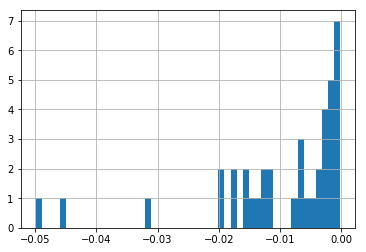

In [11]:
up_volbars.loc[down_revers_filter,'pct_change-1'].hist(bins=BINS);

Více se mi ale líbí možnosti knihovny [seaborn](https://seaborn.pydata.org/), která využívá `pandas.DataFrame` a `pandas.Series` jako vstupní data a pro statistické účely je dokáže pěkně zobrazit.

Funkce `Pandas.DataFrame.describe()` vypočítá pro dané data základní statistické údaje jako jsou průměr, směrodatná odchylka, atd.

count    39.000000
mean     -0.009638
std       0.011602
min      -0.049907
25%      -0.014155
50%      -0.006059
75%      -0.001745
max      -0.000133
Name: pct_change-1, dtype: float64

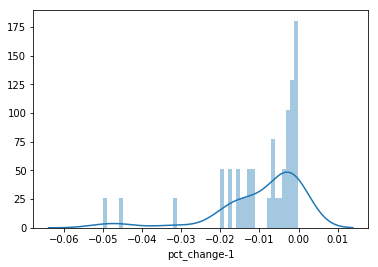

In [13]:
import seaborn as sns
sns.distplot(up_volbars.loc[down_revers_filter,'pct_change-1'], bins=BINS)
up_volbars.loc[down_revers_filter,'pct_change-1'].describe()

### Rozložení velikosti výnosů up reverzu po down volatilním pohybu

Podobný rozbor pro reverzní pohyb po volatilní klesající úsečce:

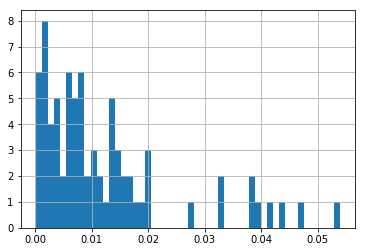

In [14]:
down_volbars.loc[up_revers_filter,'pct_change-1'].hist(bins=BINS);

count    77.000000
mean      0.012079
std       0.012155
min       0.000140
25%       0.004028
50%       0.007945
75%       0.015022
max       0.053943
Name: pct_change-1, dtype: float64

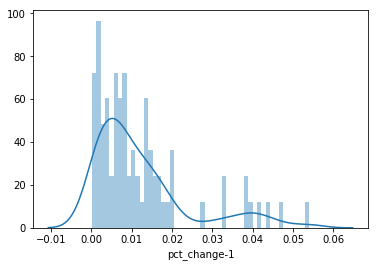

In [15]:
sns.distplot(down_volbars.loc[up_revers_filter,'pct_change-1'], bins=BINS)
down_volbars.loc[up_revers_filter,'pct_change-1'].describe()

# Výsledek

Z výše popsané analýzy jsem zjistil následující charakteristiku pro volatilní svíčky v trhu SPY v časovém období od 1.1.2005 do 31.12.2018:

* Po volatilní stoupající svíčce následovala reverzní svíce (klesající) v **44.83% případů**.
* Po volatilní klesající svíčce následovala reverzní svíce (stoupající) v **57.89% případů**.

Už tenhle první výsledek nám ukazuje, že:

>**Má větší smysl hledat v trhu SPY reverz po klesající volatilní úsečce směrem nahoru**.

Samozřejmě je to dáno charakterem trhu SPY. Na grafu SPY je možné vidět na první pohled, že má spíše tendenci stoupat:

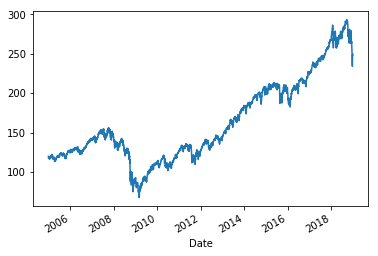

In [16]:
spy_data.Close.plot();

V případě, že se na základě výsledků předchozí analýzy rozhodnu obchodovat nákupem na `Close` klesající volatilní úsečky, můžu pomocí analýzy výnosů zjistit, kam až se v následujícím dnu může trh dostat a mířit tam profit target.

Uzavírací cena po klesající volatilní úsečce se **v 57,89% případů dosáhne zhodnocení průměrně k 1.21%** (`mean=0.012079`), směrodatná odchylka je 1,22%.

> **Pokud chci uzavřít obchod hned druhý den, nemá smysl mířit s profit targetem dál než ke zhodnocení 2.43%** (průměr + směrodatná odchylka).

*V obchodování není třeba obrovské výhody, i nepatrná výhoda může mít vliv na úplně odlišný výsledek z dlouhodobého pohledu.*

# Souhrn

Tento článek slouží jako inspirace jak analyzovat vliv jedné podmínky na budoucí výsledek. Základ je mít jak data při vstupu, tak při výstupu, v tabulce na jednom řádku a pak zkoumat vliv vstupní a výstupní podmínky.

Pro příklad jsem analyzoval vliv volatilních svíček na budoucí vývoj ceny v další cenové úsečce. Napadají mě hned další možnosti, jak tuhle analýzu upravit pro reálnější použití:

* změna výstupní podmínky (např. výstup na opačné volatilní úsečce)
* stanovení velikosti Profit Targetů a Stop-Lossu na základě volatility (max. velikosti ceny pohybu po vstupní podmínce) pomocí histogramu
* filtr pro určitý charakter trhu a analýza dat pouze pro daný charakter trhu jako je up-trend, down-trend, trh směřující do strany, atd.

*Pozn.: Pro jednoduchost a vysvětlení základního principu **zde neuvádím žádné ověření kvality dat, žádné ověření kvality výsledků a další důležité aspekty, k celkovému obchodnímu systému**. Jde pouze o inspiraci a v žádném případě nenesu odpovědnost za nesprávně interpretované a použité zde obsažené informace.*